In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# 加载数据
path = 'C:/Users/Fz/Fz/二手车交易价格预测/'
train = pd.read_csv(path+'train_tree.csv', sep=' ', encoding='utf-8', engine='python')
test = pd.read_csv(path+'test_tree.csv', sep=' ', encoding='utf-8', engine='python')

In [3]:
train.shape

(150000, 91)

In [4]:
X_train = train.drop('price', axis=1)
y_train = train['price']
X_test = test.drop('price', axis=1)

In [5]:
# X_train = np.array(X_train)
# y_train = np.array(y_train)
# X_test = np.array(X_test)

# **建模调参**

In [6]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error

#### **交叉验证**

In [7]:
kf = KFold(n_splits=5, shuffle=True, random_state=2020)

#### **LightGBM 模型**

In [8]:
import lightgbm as lgb

#### **参数优化**

In [9]:
from hyperopt import fmin, tpe, hp
from bayes_opt import BayesianOptimization

In [10]:
oof = np.zeros(len(X_train))
prediction_train = np.zeros(len(X_train))
prediction = np.zeros(len(X_test))

In [11]:
params = {'objective': 'mae', 
          'boosting_type': 'gbdt',
          'num_boost_round': 10**5,
          'learning_rate': 0.01,
          'num_leaves': 100,
          'max_depth': -1,
          'min_data_in_leaf': 20,
          'bagging_fraction': 0.8,
          'bagging_freq': 1,
          'feature_fraction': 0.8,
          'lambda_l2': 2,
          'max_bin': 500,
          'metrics': 'mae'
         }
params_x = params.copy()
del params_x['num_boost_round']

In [12]:
# 调整训练过程的学习率
# def reduce_lr(current_iteration):
#     lr = 0.1
#     if current_iteration  > 5*10**3 :
#         lr =  0.01
#     if current_iteration  == 5*10**3 :
#         print("lr changed to {}".format(0.01))
#     return lr

In [13]:
def lgb_cv(params_opt=params.copy()):
    params_dict = params.copy()
#     params_dict.update(params_opt)
    num_boost_round = params_dict['num_boost_round']
    params_dict_x = params_x.copy()
#     params_dict_x.update(params_opt)
    for train_id, valid_id in kf.split(X_train, y_train):
        train_data = lgb.Dataset(X_train.iloc[train_id], y_train.iloc[train_id])
        valid_data = lgb.Dataset(X_train.iloc[valid_id], y_train.iloc[valid_id])
        model = lgb.train(params_dict_x, train_data, num_boost_round, [train_data, valid_data],
                          verbose_eval=5*10**3, early_stopping_rounds=10**3, callbacks=[])
        oof[valid_id] = model.predict(X_train.iloc[valid_id], num_iteration=model.best_iteration)
        global prediction
        prediction += model.predict(X_test, num_iteration=model.best_iteration) / kf.n_splits
        print(mean_absolute_error(np.expm1(oof[valid_id]), np.expm1(y_train.iloc[valid_id])))
    score = mean_absolute_error(np.expm1(oof), np.expm1(y_train))
    return score

In [14]:
score = lgb_cv()

Training until validation scores don't improve for 1000 rounds
[2000]	training's l1: 0.107972	valid_1's l1: 0.116975
[4000]	training's l1: 0.100203	valid_1's l1: 0.11288
[6000]	training's l1: 0.0956189	valid_1's l1: 0.111373
[8000]	training's l1: 0.0923977	valid_1's l1: 0.110577
[10000]	training's l1: 0.0899343	valid_1's l1: 0.110096
[12000]	training's l1: 0.0878369	valid_1's l1: 0.109723
[14000]	training's l1: 0.0861594	valid_1's l1: 0.109463
[16000]	training's l1: 0.0846287	valid_1's l1: 0.109242
[18000]	training's l1: 0.0833145	valid_1's l1: 0.109051
[20000]	training's l1: 0.0820518	valid_1's l1: 0.108884
[22000]	training's l1: 0.0809278	valid_1's l1: 0.108766
[24000]	training's l1: 0.0799972	valid_1's l1: 0.108671
[26000]	training's l1: 0.0791289	valid_1's l1: 0.108593
[28000]	training's l1: 0.0783208	valid_1's l1: 0.108516
[30000]	training's l1: 0.0775384	valid_1's l1: 0.108454
[32000]	training's l1: 0.0767456	valid_1's l1: 0.108385
[34000]	training's l1: 0.0760465	valid_1's l1: 0

In [15]:
print('lightgbm score: ' + str(score))

lightgbm score: 456.29135563419146


In [ ]:
train_ids = []
valid_ids = []
for train_id, valid_id in kf.split(X_train, y_train):
    train_ids.append(train_id)
    valid_ids.append(valid_id)

In [ ]:
def lgb_cv_0(params_opt=params.copy()):
    params_dict = params.copy()
    params_dict.update(params_opt)
    num_boost_round = params_dict['num_boost_round']
    params_dict_x = params_x.copy()
    params_dict_x.update(params_opt)
    train_id = train_ids[0]
    valid_id = valid_ids[0]
    train_data = lgb.Dataset(X_train.iloc[train_id], y_train.iloc[train_id])
    valid_data = lgb.Dataset(X_train.iloc[valid_id], y_train.iloc[valid_id])
    model = lgb.train(params_dict_x, train_data, num_boost_round, [train_data, valid_data],
                      verbose_eval=10**3, early_stopping_rounds=5*10**2)
    oof[valid_id] = model.predict(X_train.iloc[valid_id], num_iteration=model.best_iteration)
    score = mean_absolute_error(np.expm1(oof.iloc[valid_id]), np.expm1(y_train.iloc[valid_id]))
    return score

In [ ]:
params_opt = {
#               'num_boost_round': hp.choice('num_boost_round', range(10, 10^4+1)), 
#               'learning_rate': hp.uniform('learning_rate', 0.01, 10),
              'num_leaves': hp.randint('num_leaves', 5, 100+1),
              'max_depth': hp.randint('max_depth', 1, 10+1),
#               'min_data_in_leaf': (10, 1000),
#               'bagging_fraction': (0.01, 1),
#               'bagging_freq': (1, 1000),
#               'feature_fraction': (0.01, 1),
#               'lambda_l2': (0.01, 100),
#               'max_bin': (10, 1000)
              }

In [ ]:
best = fmin(fn=lgb_cv_0,
            space=params_opt,
            algo=tpe.suggest,
            max_evals=25)

In [ ]:
print('best: ' + str(best))

In [ ]:
best['learning_rate'] = 0.5

In [ ]:
score = lgb_cv(best)

In [ ]:
print('lightgbm score: ' + str(score))

In [ ]:
for train_id, valid_id in kf.split(X_train, y_train):
    train_data = lgb.Dataset(X_train[train_id], y_train[train_id])
    valid_data = lgb.Dataset(X_train[valid_id], y_train[valid_id])
    num_round = 10^3
    model = lgb.train(params, train_data, num_round, valid_sets=[train_data, valid_data],
                      verbose_eval=num_round*10, early_stopping_rounds=10^2, feval=myFeval)
    oof[valid_id] = model.predict(X_train[valid_id], num_iteration=model.best_iteration)
    prediction += model.predict(X_test, num_iteration=model.best_iteration) / kf.n_splits
features = train.columns.to_list()
features.remove('price')
features_importance = pd.DataFrame({'importance': model.feature_importance()}, index=features).sort_values(by='importance', ascending=False)

In [ ]:
print("lightgbm score: {:<8.2f}".format(mean_absolute_error(np.expm1(oof), np.expm1(y_train))))

#### **预测结果**

<AxesSubplot:>

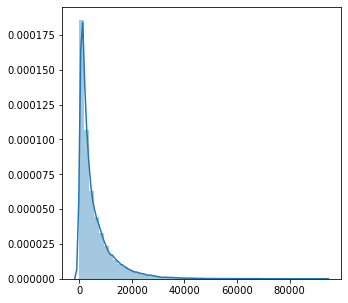

In [16]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.distplot(np.expm1(prediction))

In [17]:
path = 'C:/Users/Fz/Fz/二手车交易价格预测/'
test_0 = pd.read_csv(path+'used_car_testB_20200421.csv', sep=' ', encoding='utf-8', engine='python')

In [18]:
submission = test_0[['SaleID']].copy()
submission['price'] = np.expm1(prediction)

In [19]:
submission.to_csv(path+'submission.csv', index=False)